<font color='blue'> **44b_Beta** </font> 
<font color='red'> **_______________________________  _______________________________** </font> 

In [11]:
import os ; from pathlib import Path ; from pprint import pformat ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.utils.util_array import read1d
from modflow_devtools.misc import get_env ;write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)
_R = Path("_R")   ; _R.mkdir(exist_ok=True); DA = Path('_R/44b_beta'); DA.mkdir(exist_ok=True)   ; from flopy.plot.styles import styles ; import pandas as pd 
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MT3D') ; sim_name = '44_ex-gwt-mt3dms-p08' ; import csv; REF2=Path("E:/15_REPOS/02_Beta-Me/data/Krig/Beta03")

In [12]:
#nlay=27;nrow=1;ncol=100                                    ; delr=0.25;delc=1.0;delz=0.25                              ; nouter,ninner=100,300 ;hclose,rclose,relax=1e-6,1e-6,1.0;percel=1.0
nlay=27;nrow=1;ncol=50                                    ; delr=5.0;delc=1.0;delz=0.25                               ; nouter,ninner=100,300;hclose,rclose,relax=1e-6,1e-6,1.0;percel=1.0
k1 = 5e-4 / 100.0 * 86400  ;  k2 = 1e-2 / 100.0 * 86400    ; k11 = k1 * np.ones((nlay, nrow, ncol), dtype=float)       ; k11[11:19,:,0:24]=k2 ; k11[11:19,:,36:]=k2  ; idomain = 1

prsity=0.35 ; sconc=0.0   ; top=0   ;botm=[top-delz*k for k in range(1,nlay+1)]   ;k33=k11  ; icelltype=6*[1]+21*[0]         ; mixelm = -1  ;length_units="meters";time_units="days" 
laytyp = 6 * [1] + 21 * [0]  ; rech = 10/100/365           ; trpt= 0.01; trpv=0.01   ; dmcoef = 1.34e-5/100/100*86400  ; al=0.5 ; ath1 =al*trpt ;atv=al*trpv          # |dmcoef|cm^2/s->m^2/d  

with open(REF2/'CHD.csv', mode='r') as file:                                      
    csv_reader = csv.reader(file)  ; data = []
    for row in csv_reader:
        try:                        CC = [int(row[0]), int(row[1]), int(row[2]), float(row[3]), int(row[4])] ; data.append(CC)
        except ValueError as e:     print(f"Error converting row: {row} - {e}")
CHD = {0: data} 

perlen = [5 * 365, 15 * 365]    ; nper = len(perlen) ; nstp = [365, 1095] ; tsmult = [1.0, 1.0]     
tdis_rc = []
for i in range(nper):   tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
REC=[("CONCENTRATION","LAST"),("CONCENTRATION","STEPS","73","146","219","292","365","438","511","584","657","730","803","876","949","1022","1095","1168","1241","1314","1387","1460",),
     ("BUDGET","LAST"),]        ; CAN = [("COLUMNS",10,"WIDTH",15,"DIGITS",6,"GENERAL")]

In [13]:
with open(REF2/'CNC1.csv', mode='r') as file:                                      
    csv_reader = csv.reader(file)  ; data2 = []
    for row in csv_reader:
        try:                        CC = [int(row[0]), int(row[1]), int(row[2]), float(row[3])] ; data2.append(CC)
        except ValueError as e:     print(f"Error converting row: {row} - {e}")
with open(REF2/'CNC0.csv', mode='r') as file:                                      
    csv_reader = csv.reader(file)  ; data3 = []
    for row in csv_reader:
        try:                        CC = [int(row[0]), int(row[1]), int(row[2]), float(row[3])] ; data3.append(CC)
        except ValueError as e:     print(f"Error converting row: {row} - {e}")
CNC = {0: data2, 1: data3}   ; #CNC

In [14]:
def build_models(mixelm=0, silent=False):
    global sim ,gwf, gwt , npf , DB
    name = "p08"    ;gwfname="gwf-"+name ;gwtname="gwt-"+name   ; DB = os.path.join(DA/name)    ; sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=DB)
    
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)     
    gwf    = flopy.mf6.ModflowGwf (sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms (sim,print_option="summary",complexity="complex",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="dbd",linear_acceleration="BICGSTAB",
            under_relaxation_theta=0.7,under_relaxation_kappa=0.08,under_relaxation_gamma=0.05,under_relaxation_momentum=0.0,backtracking_number=20,backtracking_tolerance=2.0,
            backtracking_reduction_factor=0.2,backtracking_residual_limit=5.0e-4,inner_dvclose=hclose,rcloserecord="0.0001 relative_rclose",inner_maximum=ninner,relaxation_factor=relax,
            number_orthogonalizations=2,preconditioner_levels=8,preconditioner_drop_tolerance=0.001,filename=f"{gwfname}.ims")             ; sim.register_ims_package(imsgwf, [gwf.name])          
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain,filename=f"{gwfname}.dis",)
    npf = flopy.mf6.ModflowGwfnpf (gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k11,save_specific_discharge=True,filename=f"{gwfname}.npf")
    sto = flopy.mf6.ModflowGwfsto (gwf, ss=0, sy=0)                                                   ; flopy.mf6.ModflowGwfic(gwf, strt=0, filename=f"{gwfname}.ic")     
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(CHD),   stress_period_data=CHD,  save_flows=False,auxiliary="CONCENTRATION",pname="CHD-1",filename=f"{gwfname}.chd")
    flopy.mf6.ModflowGwfrcha (gwf,print_flows=True,recharge=rech,pname="RCH-1",filename=f"{gwfname}.rch") ; SA=[("HEAD", "LAST"), ("BUDGET", "LAST")]
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",headprintrecord=CAN,saverecord=SA,printrecord=SA)
    
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")         ; gwt.name_file.save_flows = True  ; FI = f"{gwtname}.ic"
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="summary",complexity="complex",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="dbd",linear_acceleration="BICGSTAB",
            under_relaxation_theta=0.7,under_relaxation_kappa =0.08  ,under_relaxation_gamma =0.05 ,under_relaxation_momentum=0.0,backtracking_number=20,backtracking_tolerance=2.0,
            backtracking_reduction_factor=0.2,backtracking_residual_limit  =5.0e-4,inner_dvclose=hclose   ,rcloserecord="0.0001 relative_rclose",inner_maximum=ninner,relaxation_factor=relax,
            number_orthogonalizations=2  ,preconditioner_levels=8,preconditioner_drop_tolerance=0.001  ,filename=f"{gwtname}.ims")             ;sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain,filename=f"{gwtname}.dis") ;flopy.mf6.ModflowGwtic(gwt,strt=sconc,filename=FI)
    if mixelm >= 0:     scheme = "UPSTREAM"
    elif mixelm == -1:  scheme = "TVD"
    else:               raise Exception()
    flopy.mf6.ModflowGwtadv (gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:                                                                                flopy.mf6.ModflowGwtdsp(gwt,alh=al,ath1=ath1,atv=atv,filename=f"{gwtname}.dsp")
    flopy.mf6.ModflowGwtmst (gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,bulk_density=None,distcoef=None,filename=f"{gwtname}.mst") 
    flopy.mf6.ModflowGwtssm (gwt, sources=[("CHD-1", "AUX", "CONCENTRATION")], filename=f"{gwtname}.ssm")  ; PRINT = [("CONCENTRATION", "LAST"), ("BUDGET", "LAST")]
    flopy.mf6.ModflowGwtoc  (gwt,budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",concentrationprintrecord=CAN,saverecord=REC ,printrecord=PRINT)
    cnc = flopy.mf6.ModflowGwtcnc (gwt,print_flows=True,stress_period_data=CNC,pname="CNC-1",filename=f"{gwtname}.cnc")   
    flopy.mf6.ModflowGwfgwt (sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")      ; return sim

def write_models(sim, silent=True):  sim.write_simulation(silent=silent)
def run_models(sim, silent=True):    success, buff = sim.run_simulation(silent=silent, report=True)                              ; assert success, pformat(buff)

def scenario(idx, silent=True): 
    sim = build_models(mixelm=mixelm)
    if write:       write_models(sim, silent=True)
    if run:         run_models(sim, silent=silent)              
scenario(0, silent=True)    # 26'' 

In [15]:
DC = list(os.listdir(DA)) # ;print(list(os.listdir(DA)))
F3 = os.path.join(DA/DC[0]/'gwf-p08.hds') ;hdobj=flopy.utils.HeadFile(F3)                             ; HH=hdobj.get_data()                  ; TI=hdobj.get_times()
sim.set_sim_path(os.path.join(DA/DC[0]))  ; gwt = sim.get_model(list(sim.model_names)[1])             ; ucnobj = gwt.output.concentration()  ; CC = ucnobj.get_alldata() 
from flopy.utils.postprocessing import get_water_table      ; LEV=np.arange(HH.min(),0,-HH.min()/10)  ; wt=get_water_table(HH)               # mx.plot_surface(wt, color="r", lw=3)

In [16]:
S = .02     ; print(HH.max(), HH.min(),'_____',np.quantile(HH, S))
S = .6      ; print(CC.max(), CC.min(),'_____',np.quantile(CC, S))
LH=np.arange(0,np.quantile(HH, S),np.quantile(HH, S)/5)  ; LH= np.flip(LH) ;
LC=np.arange(np.quantile(CC, S),CC.max(),CC.max()/5)     

0.00013248027561774998 -1e+30 _____ -1e+30
1.0 -1e+30 _____ 0.01338320563302671


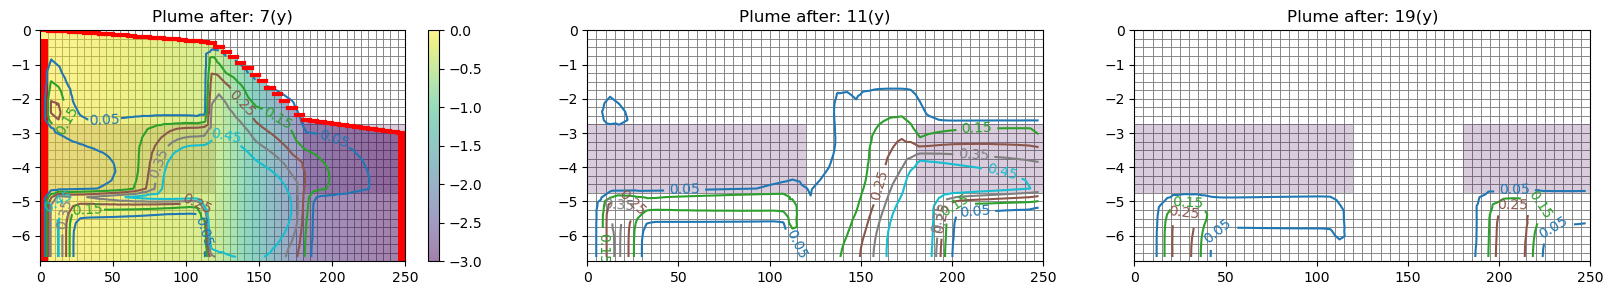

In [17]:
fig = plt.figure(figsize=(20, 3))  ; SELECT=[7,11,19] ;CL=np.arange(0.05,CC.max()/2,CC.max()/10)                  ; K=gwf.npf.k.array       ;RR={'Row':0};MV=[K[0,0,0]] # CC levels=CL

A=0; ax = fig.add_subplot(131) ;mx=flopy.plot.PlotCrossSection(model=gwf,line=RR) ; mx.plot_grid(lw=0.5)          ; cx=mx.plot_array(K, masked_values=MV, alpha=0.2)
cs = mx.contour_array(CC[SELECT[A]],cmap='tab10',levels=CL);plt.clabel(cs, fmt=r"%4.2f")                                    ; plt.title("Plume after: "+str(SELECT[A]) + "(y)")
cv = mx.contour_array(HH, colors='black');plt.clabel(cv, fmt=r"%4.2f");HV=mx.plot_array(HH,head=HH,alpha=0.5)     ; fig.colorbar(HV) ; mx.plot_bc("CHD",color ='red') ; mx.plot_surface(wt, color="r", lw=3)


B=1; ax = fig.add_subplot(132) ;mx=flopy.plot.PlotCrossSection(model=gwf,line=RR) ; mx.plot_grid(lw=0.5)           ; cx=mx.plot_array(K, masked_values=MV, alpha=0.2)
cs = mx.contour_array(CC[SELECT[B]],cmap='tab10',levels=CL);plt.clabel(cs, fmt=r"%4.2f")                                     ; plt.title("Plume after: "+str(SELECT[B]) + "(y)") 
C=2; ax = fig.add_subplot(133) ;mx=flopy.plot.PlotCrossSection(model=gwf,line=RR) ; mx.plot_grid(lw=0.5)           ; cx=mx.plot_array(K, masked_values=MV, alpha=0.2)
cs = mx.contour_array(CC[SELECT[C]],cmap='tab10',levels=CL)                                 ; plt.clabel(cs, fmt=r"%4.2f")   ; plt.title("Plume after: "+str(SELECT[C]) + "(y)") ; plt.show()

In [18]:
DB = Path(DB)  
pd.DataFrame(tdis_rc).to_csv(DB/"01_tdis_rc.csv")
with open(DB/'02_temp_08.csv', "w") as file:
    for item in TI: file.write("%s\n" % item)
with open(DB/'03_REC.csv', "w") as file:
    for item in REC[1]: file.write("%s\n" % item)

In [19]:
cncspd_1 = [] ; cnc_1 = 1  
for aa in np.arange(8, 16):           cncspd_1.append([(aa, 0, 1)])
print(cncspd_1); NP = np.array(cncspd_1); print(NP.shape); print(K.shape)   ## ... cx=mx.plot_array(NP) ... = = 27,1,50 (000 1)

[[(8, 0, 1)], [(9, 0, 1)], [(10, 0, 1)], [(11, 0, 1)], [(12, 0, 1)], [(13, 0, 1)], [(14, 0, 1)], [(15, 0, 1)]]
(8, 1, 3)
(27, 1, 50)


In [20]:
CC[SELECT[C]].shape

(27, 1, 50)